In [10]:
import pandas as pd
import numpy as np
import simpy
import random
menu_df = pd.read_csv('menu.csv')
menu_df

,ID,Item,Price,Margin,Gross Profit Per Item,Popularity,Prep_Time
0,1,847 Burger Half-Pound,$8.00,70%,$5.60,5,0.50
1,2,847 Burger Full-Pound,$10.00,70%,$7.00,4,1.00
2,3,Milkshake Small,$5.00,80%,$4.00,2,1.50
3,4,Milkshake Large,$7.00,80%,$5.60,3,2.00
4,5,Drink Small,$3.00,90%,$2.70,3,0.50
5,6,Drink Large,$4.00,90%,$3.60,4,0.75
6,7,Fries Small,$4.00,70%,$2.80,5,0.50
7,8,Fries Large,$7.00,70%,$4.90,3,1.00
8,9,Ice Cream,$9.00,85%,$7.65,1,2.00
9,10,Peanuts,$3.00,80%,$2.40,2,0.25


In [11]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

PERCENT_SUBSCRIBERS = 0.10  # Percentage of customers who are subscribers
PREMIUM_MEMBERSHIP_PRICE = 20  # Adjustable premium membership price
NUM_CUSTOMERS = 1000  # Total number of unique customers in the customer base


customer_ids = range(1, NUM_CUSTOMERS + 1)
is_subscriber = np.random.rand(NUM_CUSTOMERS) < PERCENT_SUBSCRIBERS
price_tolerance = np.random.normal(20, 5, NUM_CUSTOMERS)  # Normal dist with mean 20 and std 5
customer_base_df = pd.DataFrame({
    'CustomerID': customer_ids, 
    'IsSubscriber': is_subscriber,
    'PriceTolerance': price_tolerance
})
customer_base_df.to_csv('customer_base.csv', index=False)
customer_base_df

,CustomerID,IsSubscriber,PriceTolerance
0,1,False,20.888505
1,2,False,13.323278
2,3,False,21.900989
3,4,False,23.052929
4,5,False,22.798952
...,...,...,...
995,996,True,13.399887
996,997,False,16.941155
997,998,False,19.814816
998,999,False,17.853489


In [12]:

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

DAYS_IN_SIMULATION = 30
SIMULATION_TIME_PER_DAY = 8 * 60  # 8 hours per day in minutes
ARRIVAL_RATE = 2  # Average time between arrivals
MAX_QUEUE_LENGTH_REGULAR = 5  # Maximum queue length before regular customers start balking
MAX_QUEUE_LENGTH_IMPATIENT = 3  # Maximum queue length for impatient customers
RENEGING_TIME_REGULAR = 8  # Time after which a regular customer may renege
RENEGING_TIME_IMPATIENT = 3  # Time for impatient customers
IMPATIENCE_PROBABILITY = 0.15  # Probability that a customer is impatient on a given visit

customer_records = []

def choose_items(menu, num_items):
    chosen_items = random.choices(menu['ID'], weights=menu['Popularity'], k=num_items)
    return chosen_items

class Customer:
    def __init__(self, env, customer_id, queue, queue_name, day, is_subscriber, is_impatient):
        self.env = env
        self.customer_id = customer_id
        self.queue = queue
        self.queue_name = queue_name
        self.day = day
        self.is_subscriber = is_subscriber
        self.is_impatient = is_impatient

    def order(self):
        num_items_ordered = max(1, min(8, int(np.random.normal(3, 1))))
        ordered_items = choose_items(menu_df, num_items_ordered)
        total_prep_time = sum(menu_df[menu_df['ID'].isin(ordered_items)]['Prep_Time'])
        max_queue_length = MAX_QUEUE_LENGTH_IMPATIENT if self.is_impatient else MAX_QUEUE_LENGTH_REGULAR
        reneging_time = RENEGING_TIME_IMPATIENT if self.is_impatient else RENEGING_TIME_REGULAR

        record = {
            'customer_id': self.customer_id,
            'is_subscriber': self.is_subscriber,
            'is_impatient': self.is_impatient,
            'queue_name': self.queue_name,
            'day': self.day,
            'arrival_time': self.env.now,
            'num_items_ordered': num_items_ordered
        }

        for i in range(1, 8):
            record[f'item{i}'] = ordered_items[i - 1] if i <= len(ordered_items) else None

        with self.queue.request() as request:
            if len(self.queue.queue) > max_queue_length:
                record['action'] = 'balked'
                customer_records.append(record)
                return

            yield request | self.env.timeout(reneging_time)
            yield self.env.timeout(total_prep_time)

            record['departure_time'] = self.env.now
            record['action'] = 'served'
            customer_records.append(record)

def burger_shop(env, regular_queue, premium_queue, day, customer_base, premium_price):
    while True:
        arrival_interval = random.expovariate(1.0 / ARRIVAL_RATE)
        yield env.timeout(arrival_interval)

        selected_customer = customer_base.sample(1).iloc[0]
        customer_id = selected_customer['CustomerID']
        price_tolerance = selected_customer['PriceTolerance']
        is_subscriber = selected_customer['IsSubscriber'] or (price_tolerance >= premium_price)

        is_impatient = random.random() < IMPATIENCE_PROBABILITY
        queue = premium_queue if is_subscriber else regular_queue
        queue_name = 'premium_queue' if is_subscriber else 'regular_queue'

        customer = Customer(env, customer_id, queue, queue_name, day, is_subscriber, is_impatient)
        env.process(customer.order())

for day in range(1, DAYS_IN_SIMULATION + 1):
    env = simpy.Environment()
    regular_queue = simpy.Resource(env, capacity=1)
    premium_queue = simpy.Resource(env, capacity=1)
    env.process(burger_shop(env, regular_queue, premium_queue, day, customer_base_df, PREMIUM_MEMBERSHIP_PRICE))
    env.run(until=SIMULATION_TIME_PER_DAY)

df = pd.DataFrame(customer_records)

df['wait_time'] = df['departure_time'] - df['arrival_time']
df

,customer_id,is_subscriber,is_impatient,queue_name,day,arrival_time,num_items_ordered,item1,item2,item3,item4,item5,item6,item7,departure_time,action,wait_time
0,522,True,True,premium_queue,1,2.040121,2,2,7.0,NaN,NaN,NaN,NaN,NaN,3.540121,served,1.500000
1,303,False,False,regular_queue,1,2.683369,3,1,4.0,1.0,NaN,NaN,NaN,NaN,5.183369,served,2.500000
2,472,True,False,premium_queue,1,7.137945,3,1,2.0,6.0,NaN,NaN,NaN,NaN,9.387945,served,2.250000
3,881,True,False,premium_queue,1,8.545776,1,6,NaN,NaN,NaN,NaN,NaN,NaN,10.137945,served,1.592169
4,529,True,False,premium_queue,1,9.043829,4,7,7.0,3.0,1.0,NaN,NaN,NaN,12.637945,served,3.594116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7288,183,True,True,premium_queue,30,466.890196,2,1,5.0,NaN,NaN,NaN,NaN,NaN,469.404879,served,2.514683
7289,237,False,False,regular_queue,30,468.546696,4,10,7.0,1.0,7.0,NaN,NaN,NaN,469.796696,served,1.250000
7290,727,True,False,premium_queue,30,469.022251,1,7,NaN,NaN,NaN,NaN,NaN,NaN,469.904879,served,0.882628
7291,571,False,False,regular_queue,30,469.620593,1,5,NaN,NaN,NaN,NaN,NaN,NaN,470.296696,served,0.676103


In [13]:
df.groupby(['is_subscriber', 'is_impatient', 'queue_name', 'action'])[['action']].count()

action
is_subscriber is_impatient queue_name    action        
False         False        regular_queue served    2567
              True         regular_queue balked       2
                                         served     449
True          False        premium_queue balked       2
                                         served    3654
              True         premium_queue balked      20
                                         served     599

In [14]:
for i in range(1, 8):
    df[f'item{i}'] = df[f'item{i}'].fillna(0).astype(int)

try:
    menu_df['Gross Profit Per Item']=pd.to_numeric(menu_df['Gross Profit Per Item'].str.replace('$',''))
except:
    pass
def calculate_profit(row, menu):
    total_profit = 0.0
    for i in range(1, 8): 
        item_id = row[f'item{i}']
        if item_id!=0:
            profit = menu.loc[menu['ID'] == item_id, 'Gross Profit Per Item'].values[0]
            total_profit += profit
    return total_profit

df['profit'] = df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
df.to_csv("simulation.csv")
df

,customer_id,is_subscriber,is_impatient,queue_name,day,arrival_time,num_items_ordered,item1,item2,item3,item4,item5,item6,item7,departure_time,action,wait_time,profit
0,522,True,True,premium_queue,1,2.040121,2,2,7,0,0,0,0,0,3.540121,served,1.500000,9.8
1,303,False,False,regular_queue,1,2.683369,3,1,4,1,0,0,0,0,5.183369,served,2.500000,16.8
2,472,True,False,premium_queue,1,7.137945,3,1,2,6,0,0,0,0,9.387945,served,2.250000,16.2
3,881,True,False,premium_queue,1,8.545776,1,6,0,0,0,0,0,0,10.137945,served,1.592169,3.6
4,529,True,False,premium_queue,1,9.043829,4,7,7,3,1,0,0,0,12.637945,served,3.594116,15.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7288,183,True,True,premium_queue,30,466.890196,2,1,5,0,0,0,0,0,469.404879,served,2.514683,8.3
7289,237,False,False,regular_queue,30,468.546696,4,10,7,1,7,0,0,0,469.796696,served,1.250000,13.6
7290,727,True,False,premium_queue,30,469.022251,1,7,0,0,0,0,0,0,469.904879,served,0.882628,2.8
7291,571,False,False,regular_queue,30,469.620593,1,5,0,0,0,0,0,0,470.296696,served,0.676103,2.7


In [16]:
from scipy.optimize import minimize
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

def burger_shop(env, regular_queue, premium_queue, day, customer_base, premium_price):
    while True:
        arrival_interval = random.expovariate(1.0 / ARRIVAL_RATE)
        yield env.timeout(arrival_interval)

        selected_customer = customer_base.sample(1).iloc[0]
        customer_id = selected_customer['CustomerID']
        is_impatient = random.random() < IMPATIENCE_PROBABILITY
        price_tolerance = selected_customer['PriceTolerance']
        is_subscriber = selected_customer['IsSubscriber'] or (price_tolerance >= premium_price)

        queue = premium_queue if is_subscriber else regular_queue
        queue_name = 'premium_queue' if is_subscriber else 'regular_queue'

        customer = Customer(env, customer_id, queue, queue_name, day, is_subscriber, is_impatient)
        env.process(customer.order())

def run_simulation_for_price(premium_price, customer_base_df):
    global customer_records
    customer_records = []

    for day in range(1, DAYS_IN_SIMULATION + 1):
        env = simpy.Environment()
        regular_queue = simpy.Resource(env, capacity=1)
        premium_queue = simpy.Resource(env, capacity=1)
        env.process(burger_shop(env, regular_queue, premium_queue, day, customer_base_df, premium_price))
        env.run(until=SIMULATION_TIME_PER_DAY)

    simulation_df = pd.DataFrame(customer_records)
    for i in range(1, 8):
        simulation_df[f'item{i}'] = simulation_df[f'item{i}'].fillna(0).astype(int)
    simulation_df['profit'] = simulation_df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
    profit_per_subscriber = premium_price
    sub_profit = simulation_df[simulation_df['is_subscriber']]['customer_id'].nunique() * profit_per_subscriber
    food_profit=simulation_df['profit'].sum()
    total_profit=sub_profit+food_profit
    return total_profit

def optimize_membership_price(customer_base_df):
    def objective_function(price):
        return -run_simulation_for_price(price[0], customer_base_df)

    bounds = [(5.00, 50.00)] 

    initial_guess = [18.00]

    result = minimize(objective_function, initial_guess, bounds=bounds)

    return result, result.x[0]

# full_results, optimal_price = optimize_membership_price(customer_base_df)
# print(f"Optimal Membership Price: ${optimal_price:.2f}")


In [17]:
def run_simulation_for_price(premium_price, customer_base_df):
    global customer_records
    customer_records = []

    for day in range(1, DAYS_IN_SIMULATION + 1):
        env = simpy.Environment()
        regular_queue = simpy.Resource(env, capacity=1)
        premium_queue = simpy.Resource(env, capacity=1)
        env.process(burger_shop(env, regular_queue, premium_queue, day, customer_base_df, premium_price))
        env.run(until=SIMULATION_TIME_PER_DAY)

    simulation_df = pd.DataFrame(customer_records)
    for i in range(1, 8):
        simulation_df[f'item{i}'] = simulation_df[f'item{i}'].fillna(0).astype(int)
    simulation_df['profit'] = simulation_df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
    profit_per_subscriber = premium_price
    sub_profit = simulation_df[simulation_df['is_subscriber']]['customer_id'].nunique() * profit_per_subscriber
    food_profit=simulation_df['profit'].sum()
    total_profit=sub_profit+food_profit
    simulation_df['wait_time'] = simulation_df['departure_time'] - simulation_df['arrival_time']
    return total_profit

def run_simulation_for_dataset(premium_price, customer_base_df):
    global customer_records
    customer_records = []

    for day in range(1, DAYS_IN_SIMULATION + 1):
        env = simpy.Environment()
        regular_queue = simpy.Resource(env, capacity=1)
        premium_queue = simpy.Resource(env, capacity=1)
        env.process(burger_shop(env, regular_queue, premium_queue, day, customer_base_df, premium_price))
        env.run(until=SIMULATION_TIME_PER_DAY)

    simulation_df = pd.DataFrame(customer_records)
    for i in range(1, 8):
        simulation_df[f'item{i}'] = simulation_df[f'item{i}'].fillna(0).astype(int)
    simulation_df['profit'] = simulation_df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
    profit_per_subscriber = premium_price
    sub_profit = simulation_df[simulation_df['is_subscriber']]['customer_id'].nunique() * profit_per_subscriber
    food_profit=simulation_df['profit'].sum()
    total_profit=sub_profit+food_profit
    simulation_df['wait_time'] = simulation_df['departure_time'] - simulation_df['arrival_time']
    return simulation_df


test1=run_simulation_for_price(15, customer_base_df)
print(test1)

95303.85


In [19]:
profits = []
price= []

for prices in range(1, 36):
    profit = run_simulation_for_price(prices, customer_base_df)
    profits.append(profit)
    price.append(prices)
    print("{} Complete".format(prices))
    
sim_df1 = pd.DataFrame({'price': price, 'profit': profits})
sim_df1

1 Complete
2 Complete
3 Complete
4 Complete
5 Complete
6 Complete
7 Complete
8 Complete
9 Complete
10 Complete
11 Complete
12 Complete
13 Complete
14 Complete
15 Complete
16 Complete
17 Complete
18 Complete
19 Complete
20 Complete
21 Complete
22 Complete
23 Complete
24 Complete
25 Complete
26 Complete
27 Complete
28 Complete
29 Complete
30 Complete
31 Complete
32 Complete
33 Complete
34 Complete
35 Complete


,price,profit
0,1,81505.10
1,2,80800.50
2,3,84115.30
3,4,86194.75
4,5,85497.35
5,6,88521.60
6,7,86814.25
7,8,87748.10
8,9,89677.65
9,10,91364.30


In [44]:
sim_df1[sim_df1['profit']==sim_df1['profit'].max()]

,price,profit
8,13,95043.7


In [46]:
from IPython.display import clear_output
profits = []
price= []

for prices in range(1, 100):
    prices = 12 + prices/100
    profit = run_simulation_for_price(prices, customer_base_df)
    profits.append(profit)
    price.append(prices)
    clear_output(wait=True)
    print(prices)
    
sim_df2 = pd.DataFrame({'price': price, 'profit': profits})
sim_df2

12.99


,price,profit
0,12.01,91323.56
1,12.02,91282.19
2,12.03,94357.78
3,12.04,94166.16
4,12.05,93335.30
...,...,...
94,12.95,93675.95
95,12.96,93626.64
96,12.97,93660.88
97,12.98,92924.12


In [49]:
sim_df2[sim_df2['profit']==sim_df2['profit'].max()]

,price,profit
64,12.65,95093.7


In [51]:
optimal_price0 = sim_df2[sim_df2['profit']==sim_df2['profit'].max()]['price'].values[0]
optimal_price0

12.65

In [61]:
final_sim_df=run_simulation_for_dataset(optimal_price0, customer_base_df)
final_sim_df

,customer_id,is_subscriber,is_impatient,queue_name,day,arrival_time,num_items_ordered,item1,item2,item3,item4,item5,item6,item7,departure_time,action,profit,wait_time
0,467,True,False,premium_queue,1,0.323007,2,7,9,0,0,0,0,0,2.823007,served,10.45,2.500000
1,136,True,False,premium_queue,1,0.502344,4,1,1,5,1,0,0,0,3.823007,served,19.50,3.320663
2,912,True,False,premium_queue,1,3.312723,2,10,1,0,0,0,0,0,4.573007,served,8.00,1.260283
3,285,True,True,premium_queue,1,5.358276,3,2,5,1,0,0,0,0,7.358276,served,15.30,2.000000
4,626,True,True,premium_queue,1,6.492648,1,2,0,0,0,0,0,0,8.358276,served,7.00,1.865628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7066,5,True,True,premium_queue,30,463.637963,2,2,2,0,0,0,0,0,464.637963,served,14.00,1.000000
7067,741,True,True,premium_queue,30,466.568750,3,10,4,2,0,0,0,0,469.818750,served,15.00,3.250000
7068,401,True,True,premium_queue,30,470.760569,2,9,1,0,0,0,0,0,473.260569,served,13.25,2.500000
7069,109,True,False,premium_queue,30,472.067563,4,4,1,2,7,0,0,0,477.260569,served,21.00,5.193006


In [62]:
final_sim_df=run_simulation_for_dataset(optimal_price0, customer_base_df)

for i in range(1, 8):
    final_sim_df[f'item{i}'] = final_sim_df[f'item{i}'].fillna(0).astype(int)

final_sim_df['profit'] = final_sim_df.apply(lambda row: calculate_profit(row, menu_df), axis=1)
final_sim_df.to_csv("final_simulation.csv")

In [5]:
import pandas as pd

In [6]:
final_sim_df=pd.read_csv("final_simulation.csv")

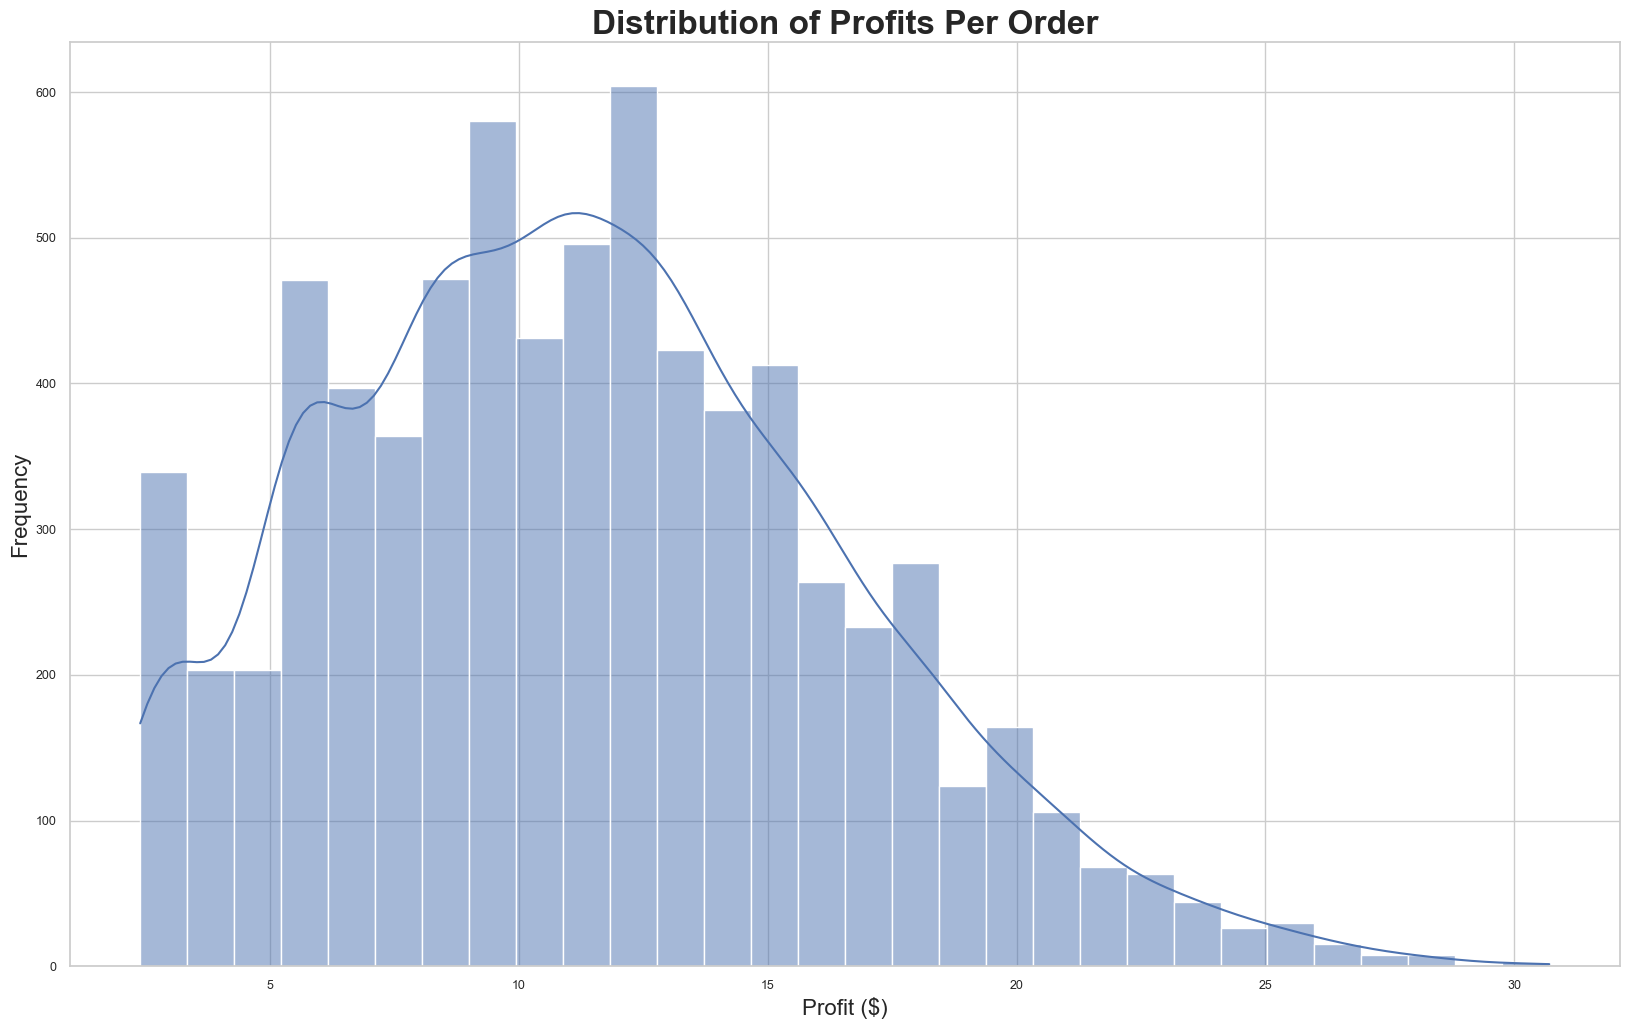

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams.update({'font.size': 16})
sns.set(style="whitegrid")

# Plotting Profit Distribution
plt.figure(figsize=(20, 12))
sns.histplot(final_sim_df['profit'], bins=30, kde=True)
plt.title('Distribution of Profits Per Order', fontdict={'fontsize': 24, 'fontweight': 'bold'})
plt.xlabel('Profit ($)',fontsize=16)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('Frequency',fontsize=16)
plt.savefig('graphs/profit.png', dpi=600)
plt.show()

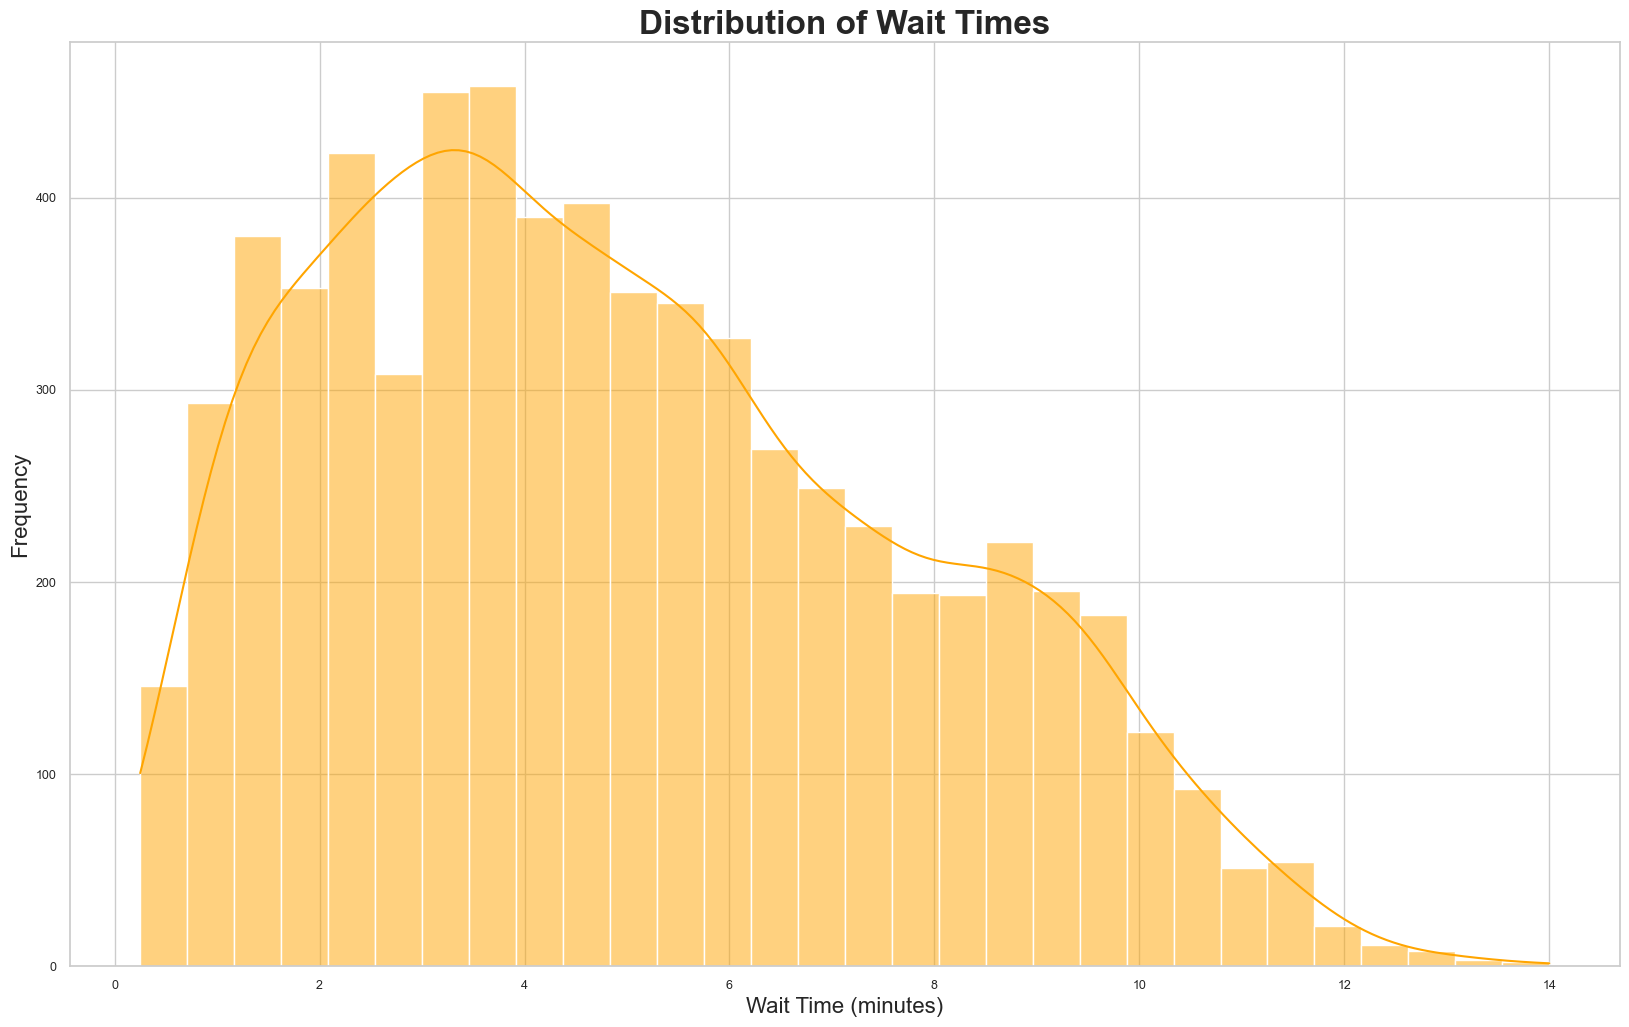

In [38]:
# Plotting Wait Time Distribution
plt.figure(figsize=(20, 12))
sns.histplot(final_sim_df['wait_time'], bins=30, kde=True, color='orange')
plt.title('Distribution of Wait Times', fontdict={'fontsize': 24, 'fontweight': 'bold'})
plt.xlabel('Wait Time (minutes)',fontsize=16)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('Frequency',fontsize=16)
plt.savefig('graphs/wait_time.png', dpi=600)
plt.show()

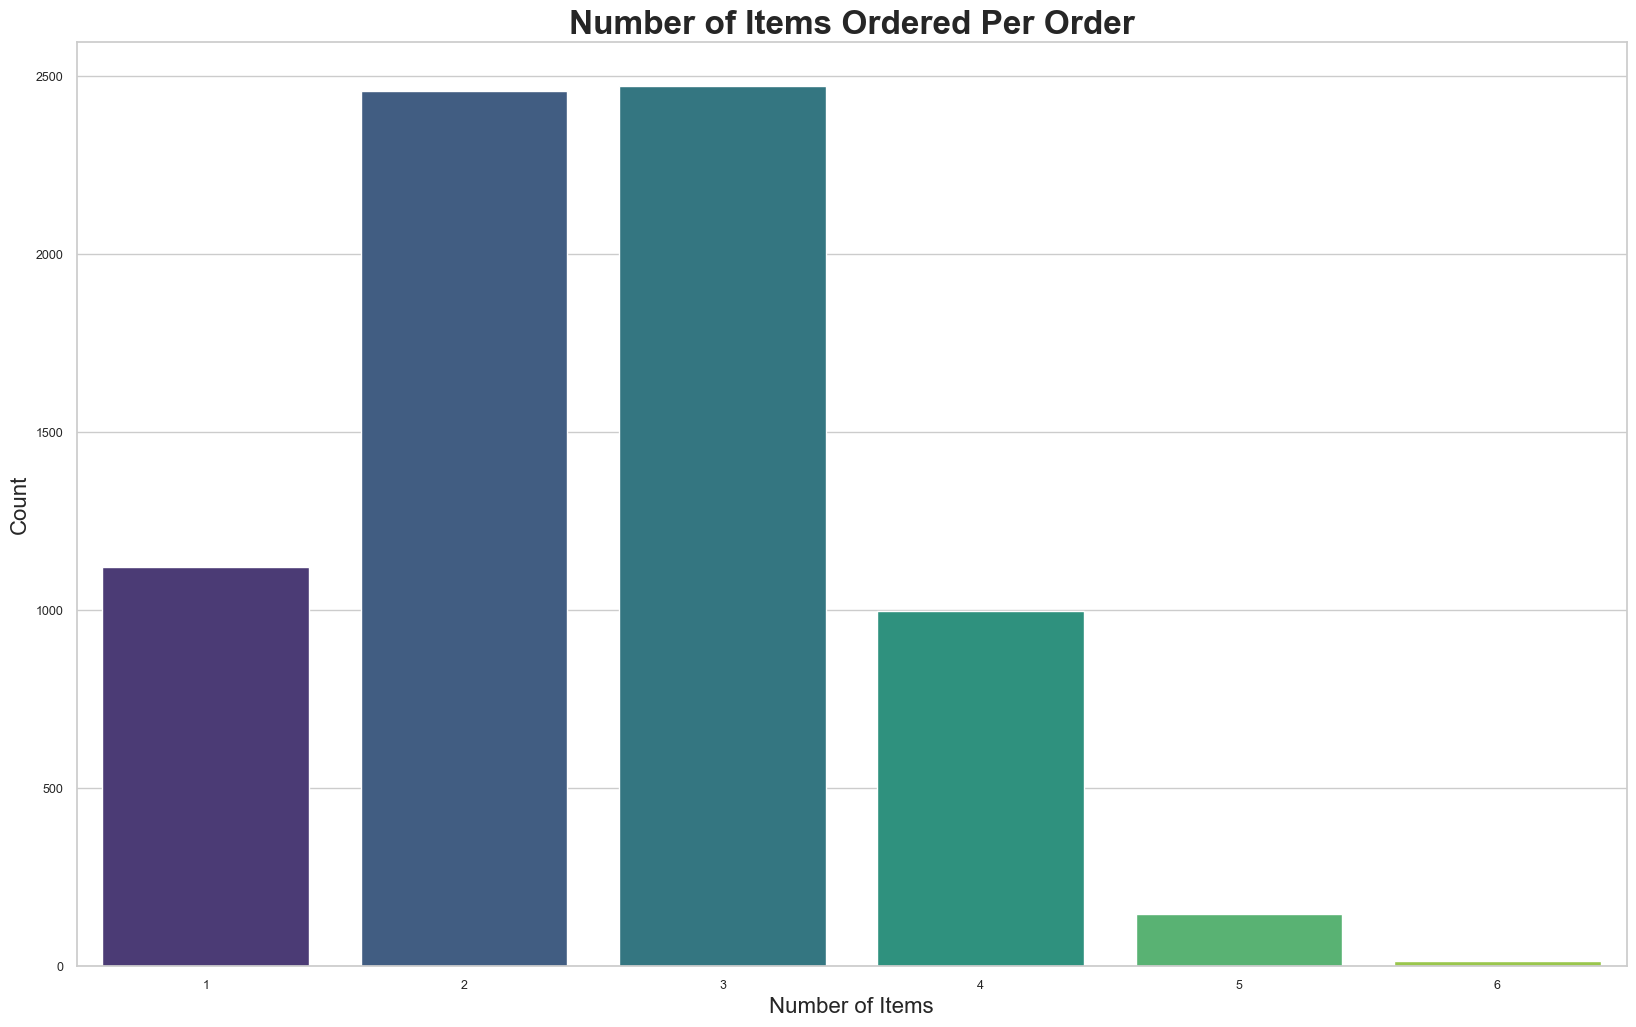

In [37]:
# Plotting Number of Items Ordered
plt.figure(figsize=(20, 12))
sns.countplot(x='num_items_ordered', data=final_sim_df, palette='viridis')
plt.title('Number of Items Ordered Per Order', fontdict={'fontsize': 24, 'fontweight': 'bold'})
plt.xlabel('Number of Items',fontsize=16)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('Count',fontsize=16)
plt.savefig('graphs/items_ordered.png', dpi=600)
plt.show()


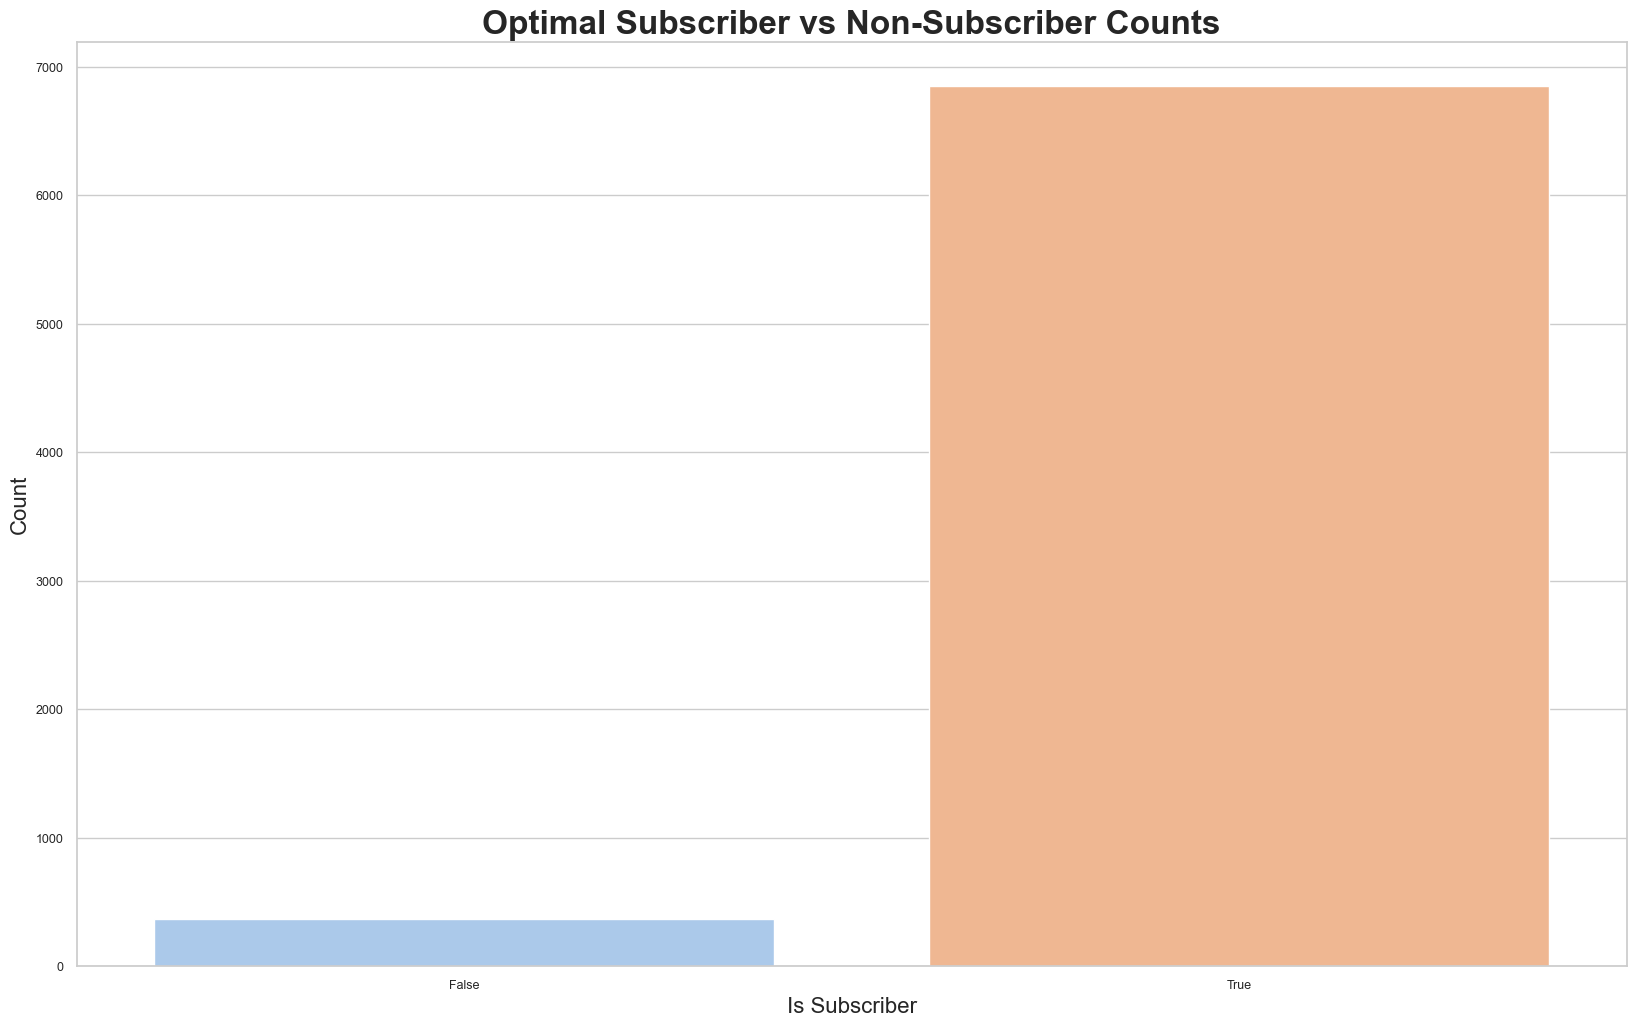

In [36]:
# Subscriber vs Non-Subscriber Counts
plt.figure(figsize=(20, 12))
sns.countplot(x='is_subscriber', data=final_sim_df, palette='pastel')
plt.title('Optimal Subscriber vs Non-Subscriber Counts', fontdict={'fontsize': 24, 'fontweight': 'bold'})
plt.xlabel('Is Subscriber',fontsize=16)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('Count',fontsize=16)
plt.savefig('graphs/subscriber.png', dpi=600)
plt.show()

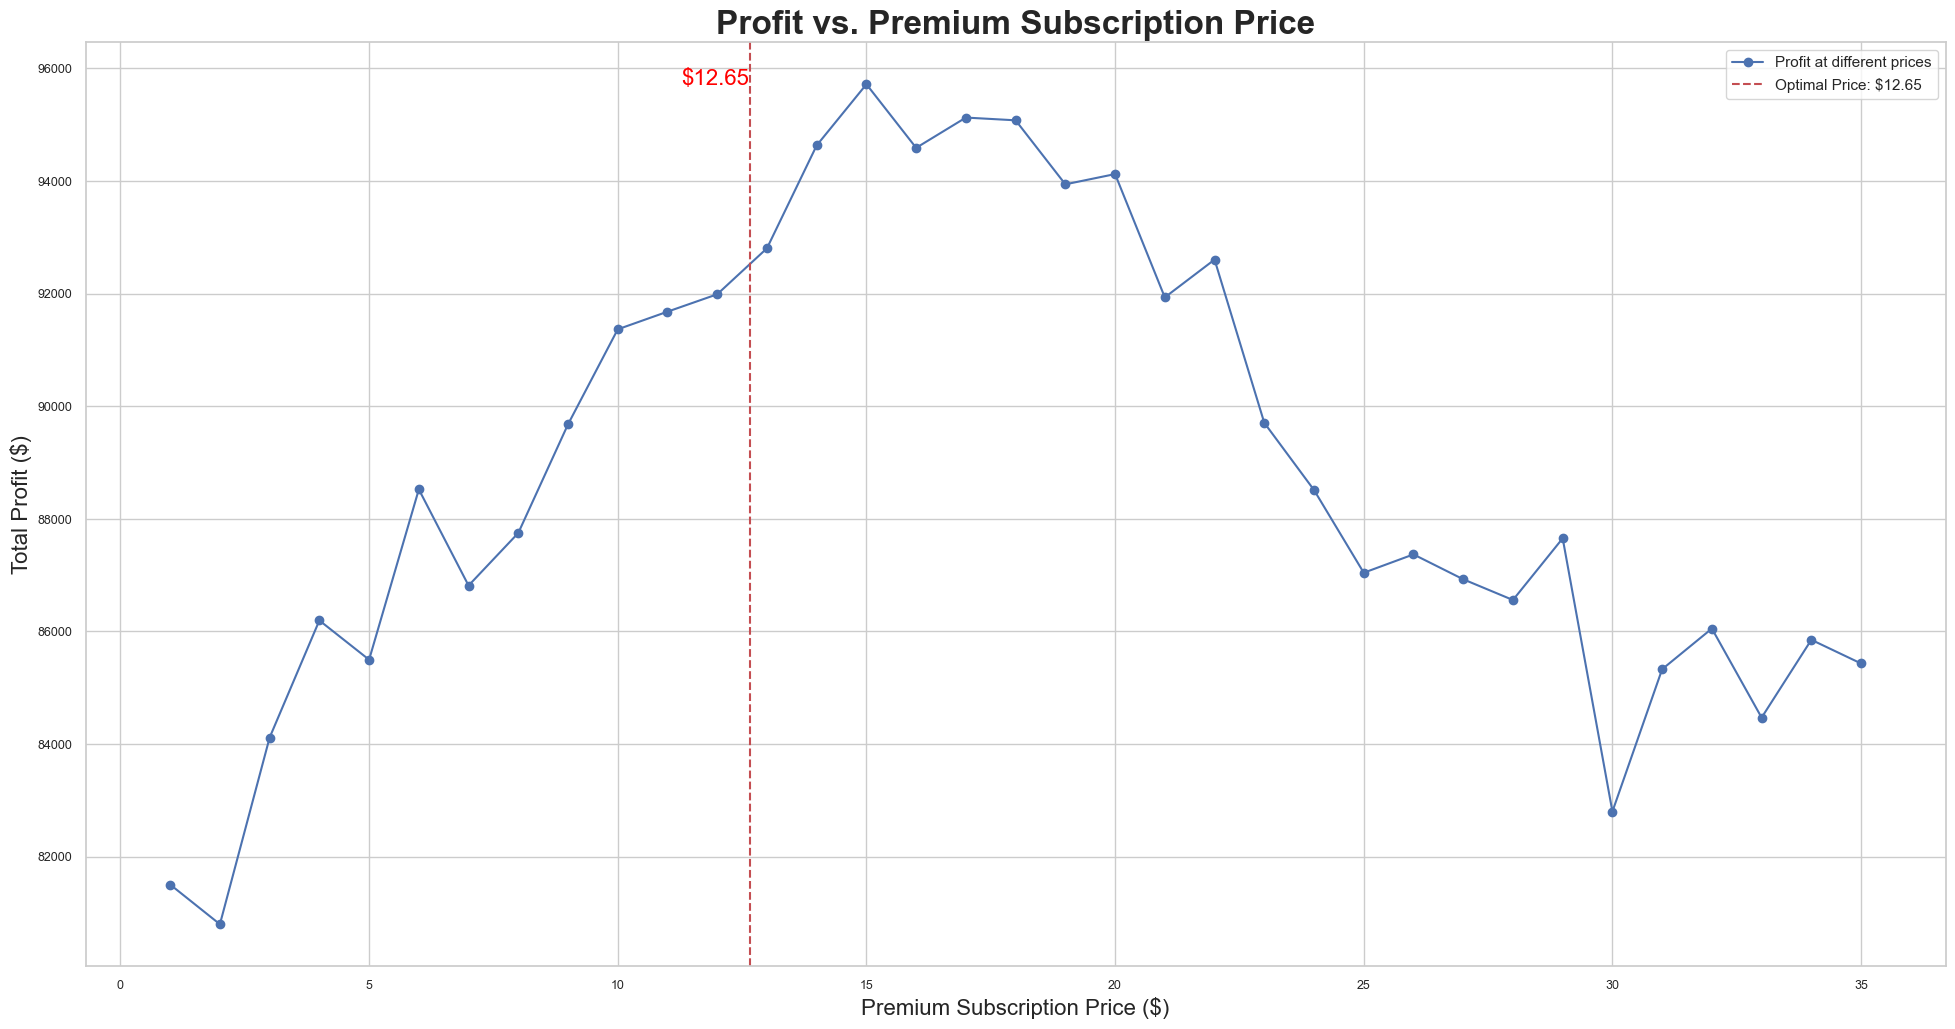

<Figure size 640x480 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
optimal_price = 12.65

plt.figure(figsize=(24, 12))
plt.rcParams.update({'font.size': 16})
plt.plot(sim_df1['price'], sim_df1['profit'], marker='o', color='b', label='Profit at different prices')
plt.axvline(x=optimal_price, color='r', linestyle='--', label=f'Optimal Price: ${optimal_price}')
plt.text(optimal_price, max(profits), f'${optimal_price}', color='red', ha='right')
plt.xlabel('Premium Subscription Price ($)',fontsize=16)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('Total Profit ($)',fontsize=16)
plt.title('Profit vs. Premium Subscription Price', fontdict={'fontsize': 24, 'fontweight': 'bold'})
plt.legend()
plt.show()
plt.savefig('graphs/optimization.png', dpi=600)
